### CBLOF Find # kmeans centroid
[Git Issue 1085](https://github.ibm.com/wiotp/monitoring-dashboard/issues/1085)

**Refrences**
* [data drifting testing](https://elvyna.github.io/2018/time-series-hypothesis-testing/)

**Goal** 
Use heuristics to determine a `good` value for # centroids and analyze if it makes anomaly detection better <br/>
* stategies used to determine number of clusters Elbow method, silouetter score, and gap statistic <br/> 
* consider effectiveness by measuring drift in data

**Progress**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt

from src.comparingmodels import (utils, data, models)

import logging
from iotfunctions.enginelog import EngineLogging
EngineLogging.configure_console_logging(logging.INFO)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/iotfunctions/bif.py:1884: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


#### STEPS TO ANALYZE CLUSTERING <br>

1. Use sample customer data to **determine data variance** across different time periods<br>
2. Perform **elbow method**, **silhouette scoring**, and **gap statistics** <br>
3. Implement max voting or avergae for determining the num of clusters<br>
4. Compare if they holds across two subsets derived from the same dataset<br>
5. Analyze if num of clusters derived from above method yieldd better results than the hardset value of k=40<br>

#### SELECT DATA TO ANALYSE <br>
uncomment the data source you want to use

In [233]:
#Select (by uncommenting) a data source
#datapath = '../data/AzureAnomalysample.csv'; datakey='Temperature'
datapath = '../data/Armstark04714B6046D5.csv'; datakey='ArmstarkGoodData'
#datapath='../data/Armstark04714B604101.csv'; datakey='ArmstarkBadData'
#datapath = '../data/Anomaly_Sample_data.csv'; datakey='SampleAnomalyData'

**1. Data Processing**

In [234]:
#-------------------------------DATA 1-------------------------------#
if datakey is "Temperature":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='timestamp')
    dp.add_entity('MyRoom')
    dp.add_derived_column('Temperature', 'value', 20)
    dp.process_data()
    df = dp.get_data()
    df = df.drop(columns=['value'])
    #column we want to analyze
    columnname='Temperature'
    entity='MyRoom'
    
#-------------------------------DATA 2-------------------------------#
if datakey is "ArmstarkGoodData":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='RCV_TIMESTAMP_UTC')
    dp.change_column_name('entity', 'DEVICE_ID')
    dp.change_column_name('timestamp', 'RCV_TIMESTAMP_UTC')
    dp.process_data()
    df = dp.get_data()

    #filter data to specific needs
    listAttr = ['timestamp', 'entity', 'vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
                'accel_power_2', 'accel_power_3', 'accel_power_4']
    utils.l2norm(df, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
    utils.l2norm(df, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
    utils.l2norm(df, 'accel_speed', 'ACCEL_SPEED')
    utils.unrollAccel(df)
    df = df.filter(listAttr, axis=1)

    #colum we want to analyze
    columnname = 'vibrations'
    entity='04714B6046D5'
    
#-------------------------------DATA 3-------------------------------#
if datakey is "ArmstarkBadData":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='RCV_TIMESTAMP_UTC')
    dp.change_column_name('entity', 'DEVICE_ID')
    dp.change_column_name('timestamp', 'RCV_TIMESTAMP_UTC')
    dp.process_data()
    df = dp.get_data()

    #filter data to specific needs
    listAttr = ['timestamp', 'entity', 'vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
                'accel_power_2', 'accel_power_3', 'accel_power_4']
    utils.l2norm(df, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
    utils.l2norm(df, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
    utils.l2norm(df, 'accel_speed', 'ACCEL_SPEED')
    utils.unrollAccel(df)
    df = df.filter(listAttr, axis=1)

    #colum we want to analyze
    columnname = 'vibrations'
    entity='04714B604101'
    
#-------------------------------DATA 4-------------------------------#
if datakey is "SampleAnomalyData":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='EVT_TIMESTAMP')
    dp.change_column_name('entity', 'DEVICEID')
    dp.change_column_name('timestamp', 'EVT_TIMESTAMP')
    dp.drop_columns(columns=['LOGICALINTERFACE_ID', 'EVENTTYPE', 'FORMAT', 'TURBINE_ID'])
    dp.process_data()
    df = dp.get_data()
    #colum we want to analyze
    columnname = 'TEMPERATURE' #PRESSURE
    entity='A101'

X = np.array(df[columnname])
try:
    X.shape[1]
except:
    X = X.reshape(-1, 1)
    
df.head()

vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B6046D5 2020-01-01 00:02:25.928    3.787826  2.171877  2316.566425   
             2020-01-01 00:07:26.074    3.776503  2.170646  2316.566425   
             2020-01-01 00:12:25.663    3.715573  2.171475  2316.566425   
             2020-01-01 00:17:26.020    3.765538  2.171679  2316.566425   
             2020-01-01 00:22:25.727    3.725934  2.170599  2316.566425   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B6046D5 2020-01-01 00:02:25.928         2.2904         2.2824   
             2020-01-01 00:07:26.074         2.2822         2.2978   
             2020-01-01 00:12:25.663         2.2718         2.2908   
             2020-01-01 00:17:26.020         2.2748         2.2932   
             2020-01-01 00:22:25.727         2.3320         2.2980   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B6046D5 2020-01-01 00:02:25.928         2.2858         2.2956   
             2020-01-01 00:07:26.074         2.2966         2.3504   
             2020-01-01 00:12:25.663         2.2912         2.3044   
             2020-01-01 00:17:26.020         2.2926         2.3146   
             2020-01-01 00:22:25.727         2.2998         2.3212   

                                      accel_power_4  
entity       timestamp                               
04714B6046D5 2020-01-01 00:02:25.928         2.3278  
             2020-01-01 00:07:26.074         2.3190  
             2020-01-01 00:12:25.663         2.3232  
             2020-01-01 00:17:26.020         2.3606  
             2020-01-01 00:22:25.727         2.2860

**2. Elbow Method**

elbow value 19
elbow score 0.07279032125557272


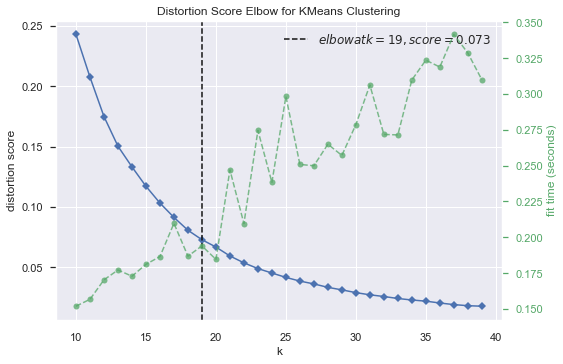

In [235]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
#timings=False to hid the green line
#metric=silhouette and calinski_harabasz
visualizer = KElbowVisualizer(KMeans(), k=(10,40))

visualizer.fit(X)  # Fit the data to the visualizer

print(f'elbow value {visualizer.elbow_value_}')
print(f'elbow score {visualizer.elbow_score_}')
visualizer.show()  # Finalize and render the figure

**3. Silouette Scoring**

elbow value 13
elbow score 0.5217669499746339


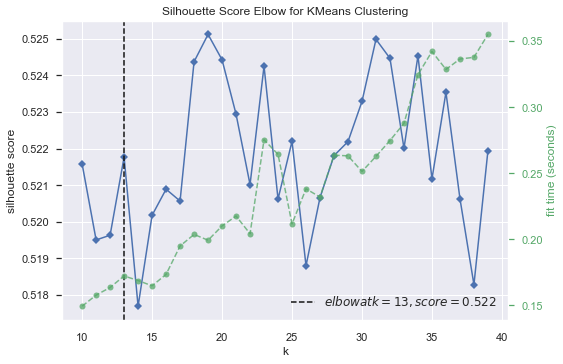

In [236]:
visualizer = KElbowVisualizer(KMeans(), k=(10,40), metric='silhouette')

visualizer.fit(X)  # Fit the data to the visualizer

print(f'elbow value {visualizer.elbow_value_}')
print(f'elbow score {visualizer.elbow_score_}')
visualizer.show()  # Finalize and render the figure

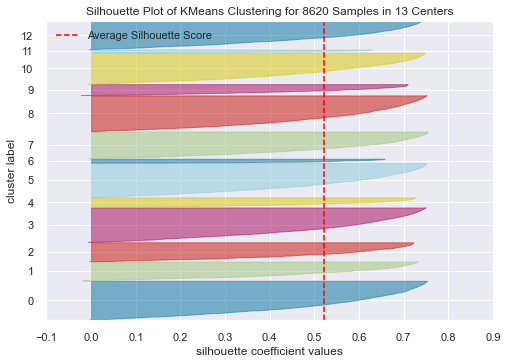

In [239]:
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(13, random_state=50)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**4. Calinski Harabasz**

elbow value 12
elbow score 41906.96042219016


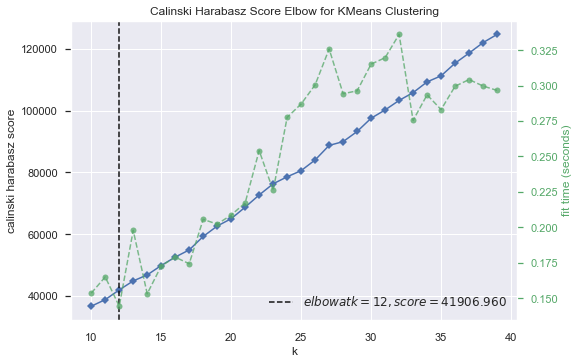

In [237]:
visualizer = KElbowVisualizer(KMeans(), k=(10,40), metric='calinski_harabasz')

visualizer.fit(X)  # Fit the data to the visualizer

print(f'elbow value {visualizer.elbow_value_}')
print(f'elbow score {visualizer.elbow_score_}')
visualizer.show()  # Finalize and render the figure

**Analyze on anomaly detection model (Running kmeans anomaly model)**

In [240]:
em = models.ExistingModels(columnname=columnname)

#add number of cluster as option
df_anomaly = em.run_kmeans(df, nclusters=19)
df_anomaly.describe()

2020-08-12T13:03:58.552 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-08-12T13:03:58.553 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-08-12T13:03:59.117 INFO iotfunctions.anomaly.execute CBLOF threshold: 0.1234781228795916


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,KmeansAnomalyScore
count,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,2.170460,2208.854495,2.453523,2.453312,2.452808,2.452053,2.452439,0.091550
std,0.033272,0.002922,589.925540,0.856247,0.857594,0.857678,0.857200,0.856340,0.024813
min,3.616515,2.155864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024766
25%,3.737696,2.169444,2316.566425,2.251800,2.251800,2.252000,2.252000,2.251800,0.076409
50%,3.757949,2.170800,2318.802493,2.313800,2.313400,2.311800,2.312200,2.312600,0.089490
75%,3.780154,2.171949,2379.176328,2.691450,2.692100,2.685100,2.681850,2.682300,0.105157
max,3.898555,2.184292,2672.101233,5.325799,5.293200,5.334001,5.278600,5.282000,0.212964


kmeans anomaly threshold: 0.16


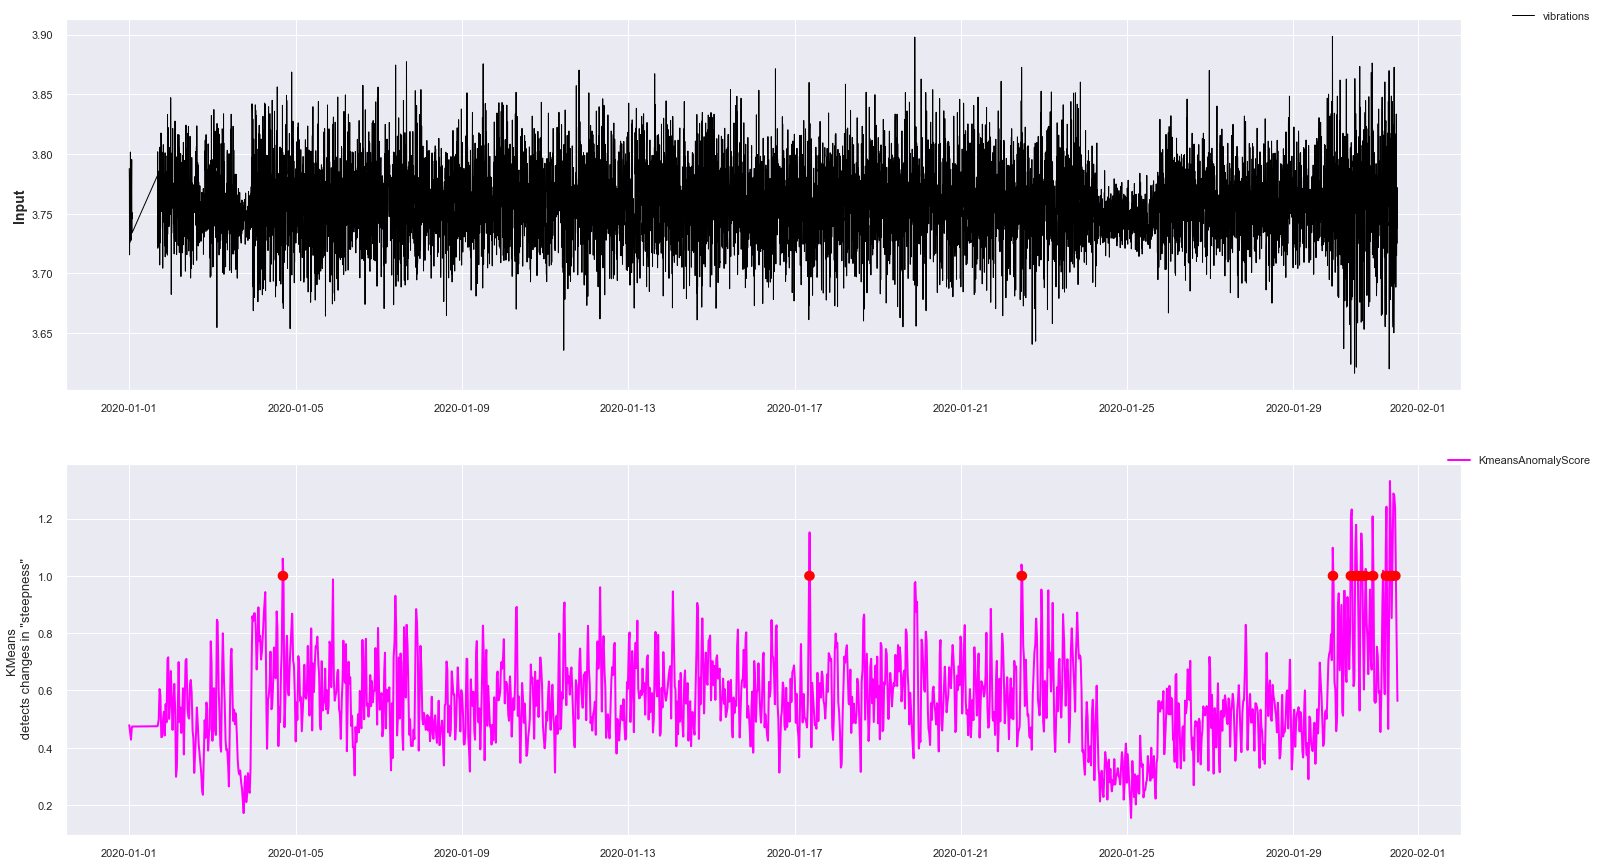

In [243]:
# Simplify dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)
df_plot = df_anomaly.loc[[entity]]
df_plot.reset_index(level=[0], inplace=True)
em.visualize_kmeans(df_plot, threshold=0.16)

**Obsevations**

Data 1:
* Using recommended threshold has false positives
* Different threshold recommendatiosn by CBLOF on different runs
* Increasing #cluster decreases the threshold
* General true detection rate remains the same
* Works well when setting a higher than recommended threshold 

Data 2:
* A lot of false positives

Data 3:

Data 4:

**Data Drift**

In [ ]:
ts = a_columns
ts.rolling(window=60).mean()